In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 128
learning_rate = 1e-3

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([128, 3, 48, 48])
out-size: torch.Size([3, 802, 402])


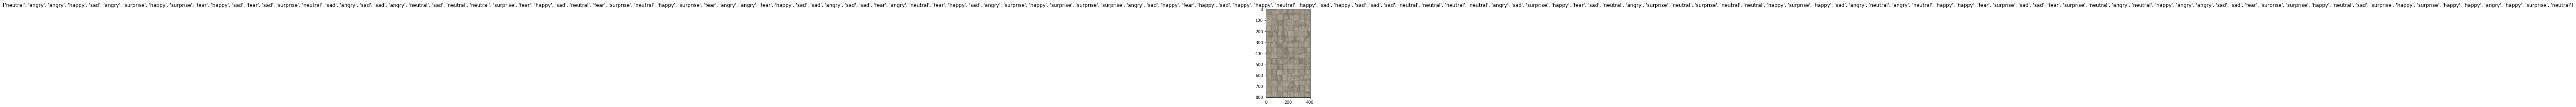

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = models.resnet18(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if device else net.fc

In [8]:
n_epochs = 150
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/150], Step [0/221], Loss: 5.2828
Epoch [1/150], Step [20/221], Loss: 2.4703
Epoch [1/150], Step [40/221], Loss: 1.9104
Epoch [1/150], Step [60/221], Loss: 1.4873
Epoch [1/150], Step [80/221], Loss: 1.4992
Epoch [1/150], Step [100/221], Loss: 1.7209
Epoch [1/150], Step [120/221], Loss: 1.7188
Epoch [1/150], Step [140/221], Loss: 1.4728
Epoch [1/150], Step [160/221], Loss: 1.5752
Epoch [1/150], Step [180/221], Loss: 1.4776
Epoch [1/150], Step [200/221], Loss: 1.4765
Epoch [1/150], Step [220/221], Loss: 1.3257

train-loss: 1.7530, train-acc: 50.7198
validation loss: 1.3958, validation acc: 55.3559

Improvement-Detected, save-model
Epoch 2

Epoch [2/150], Step [0/221], Loss: 1.2090
Epoch [2/150], Step [20/221], Loss: 1.1206
Epoch [2/150], Step [40/221], Loss: 1.3524
Epoch [2/150], Step [60/221], Loss: 1.3352
Epoch [2/150], Step [80/221], Loss: 1.2316
Epoch [2/150], Step [100/221], Loss: 1.3188
Epoch [2/150], Step [120/221], Loss: 1.2226
Epoch [2/150], Step [140/221], Loss

validation loss: 1.5360, validation acc: 59.8274

Epoch 14

Epoch [14/150], Step [0/221], Loss: 0.2563
Epoch [14/150], Step [20/221], Loss: 0.0764
Epoch [14/150], Step [40/221], Loss: 0.0706
Epoch [14/150], Step [60/221], Loss: 0.0571
Epoch [14/150], Step [80/221], Loss: 0.0915
Epoch [14/150], Step [100/221], Loss: 0.0543
Epoch [14/150], Step [120/221], Loss: 0.0998
Epoch [14/150], Step [140/221], Loss: 0.1263
Epoch [14/150], Step [160/221], Loss: 0.2110
Epoch [14/150], Step [180/221], Loss: 0.3204
Epoch [14/150], Step [200/221], Loss: 0.1403
Epoch [14/150], Step [220/221], Loss: 0.2806

train-loss: 0.5842, train-acc: 95.2570
validation loss: 1.5688, validation acc: 60.2943

Epoch 15

Epoch [15/150], Step [0/221], Loss: 0.1034
Epoch [15/150], Step [20/221], Loss: 0.1206
Epoch [15/150], Step [40/221], Loss: 0.0527
Epoch [15/150], Step [60/221], Loss: 0.1036
Epoch [15/150], Step [80/221], Loss: 0.0686
Epoch [15/150], Step [100/221], Loss: 0.0733
Epoch [15/150], Step [120/221], Loss: 0.17

validation loss: 1.8348, validation acc: 61.3556

Epoch 27

Epoch [27/150], Step [0/221], Loss: 0.0355
Epoch [27/150], Step [20/221], Loss: 0.0492
Epoch [27/150], Step [40/221], Loss: 0.0259
Epoch [27/150], Step [60/221], Loss: 0.0762
Epoch [27/150], Step [80/221], Loss: 0.0405
Epoch [27/150], Step [100/221], Loss: 0.0048
Epoch [27/150], Step [120/221], Loss: 0.1605
Epoch [27/150], Step [140/221], Loss: 0.0826
Epoch [27/150], Step [160/221], Loss: 0.0669
Epoch [27/150], Step [180/221], Loss: 0.0274
Epoch [27/150], Step [200/221], Loss: 0.0331
Epoch [27/150], Step [220/221], Loss: 0.1003

train-loss: 0.3423, train-acc: 97.8389
validation loss: 1.8504, validation acc: 60.0396

Epoch 28

Epoch [28/150], Step [0/221], Loss: 0.0155
Epoch [28/150], Step [20/221], Loss: 0.0401
Epoch [28/150], Step [40/221], Loss: 0.0148
Epoch [28/150], Step [60/221], Loss: 0.0260
Epoch [28/150], Step [80/221], Loss: 0.0566
Epoch [28/150], Step [100/221], Loss: 0.1089
Epoch [28/150], Step [120/221], Loss: 0.07

validation loss: 2.0013, validation acc: 60.0679

Epoch 40

Epoch [40/150], Step [0/221], Loss: 0.0253
Epoch [40/150], Step [20/221], Loss: 0.0080
Epoch [40/150], Step [40/221], Loss: 0.0642
Epoch [40/150], Step [60/221], Loss: 0.0040
Epoch [40/150], Step [80/221], Loss: 0.0234
Epoch [40/150], Step [100/221], Loss: 0.0883
Epoch [40/150], Step [120/221], Loss: 0.0469
Epoch [40/150], Step [140/221], Loss: 0.0220
Epoch [40/150], Step [160/221], Loss: 0.0091
Epoch [40/150], Step [180/221], Loss: 0.0109
Epoch [40/150], Step [200/221], Loss: 0.0726
Epoch [40/150], Step [220/221], Loss: 0.0432

train-loss: 0.2482, train-acc: 98.2634
validation loss: 2.0120, validation acc: 59.4312

Epoch 41

Epoch [41/150], Step [0/221], Loss: 0.0671
Epoch [41/150], Step [20/221], Loss: 0.0565
Epoch [41/150], Step [40/221], Loss: 0.0352
Epoch [41/150], Step [60/221], Loss: 0.0124
Epoch [41/150], Step [80/221], Loss: 0.0196
Epoch [41/150], Step [100/221], Loss: 0.0278
Epoch [41/150], Step [120/221], Loss: 0.09

validation loss: 2.1048, validation acc: 60.8462

Epoch 53

Epoch [53/150], Step [0/221], Loss: 0.0199
Epoch [53/150], Step [20/221], Loss: 0.0313
Epoch [53/150], Step [40/221], Loss: 0.0199
Epoch [53/150], Step [60/221], Loss: 0.0311
Epoch [53/150], Step [80/221], Loss: 0.0275
Epoch [53/150], Step [100/221], Loss: 0.0308
Epoch [53/150], Step [120/221], Loss: 0.0151
Epoch [53/150], Step [140/221], Loss: 0.0321
Epoch [53/150], Step [160/221], Loss: 0.0245
Epoch [53/150], Step [180/221], Loss: 0.0094
Epoch [53/150], Step [200/221], Loss: 0.0332
Epoch [53/150], Step [220/221], Loss: 0.0199

train-loss: 0.1972, train-acc: 98.7126
validation loss: 2.1141, validation acc: 58.2425

Epoch 54

Epoch [54/150], Step [0/221], Loss: 0.0254
Epoch [54/150], Step [20/221], Loss: 0.0356
Epoch [54/150], Step [40/221], Loss: 0.0040
Epoch [54/150], Step [60/221], Loss: 0.0265
Epoch [54/150], Step [80/221], Loss: 0.0162
Epoch [54/150], Step [100/221], Loss: 0.0121
Epoch [54/150], Step [120/221], Loss: 0.06

validation loss: 2.1864, validation acc: 60.9311

Epoch 66

Epoch [66/150], Step [0/221], Loss: 0.0408
Epoch [66/150], Step [20/221], Loss: 0.0464
Epoch [66/150], Step [40/221], Loss: 0.0150
Epoch [66/150], Step [60/221], Loss: 0.0071
Epoch [66/150], Step [80/221], Loss: 0.0043
Epoch [66/150], Step [100/221], Loss: 0.0296
Epoch [66/150], Step [120/221], Loss: 0.0045
Epoch [66/150], Step [140/221], Loss: 0.0382
Epoch [66/150], Step [160/221], Loss: 0.0032
Epoch [66/150], Step [180/221], Loss: 0.0415
Epoch [66/150], Step [200/221], Loss: 0.0202
Epoch [66/150], Step [220/221], Loss: 0.0640

train-loss: 0.1648, train-acc: 98.6666
validation loss: 2.1904, validation acc: 60.7188

Epoch 67

Epoch [67/150], Step [0/221], Loss: 0.0101
Epoch [67/150], Step [20/221], Loss: 0.0294
Epoch [67/150], Step [40/221], Loss: 0.0721
Epoch [67/150], Step [60/221], Loss: 0.0138
Epoch [67/150], Step [80/221], Loss: 0.0233
Epoch [67/150], Step [100/221], Loss: 0.0160
Epoch [67/150], Step [120/221], Loss: 0.02

validation loss: 2.2470, validation acc: 60.8179

Epoch 79

Epoch [79/150], Step [0/221], Loss: 0.0009
Epoch [79/150], Step [20/221], Loss: 0.0038
Epoch [79/150], Step [40/221], Loss: 0.0295
Epoch [79/150], Step [60/221], Loss: 0.0018
Epoch [79/150], Step [80/221], Loss: 0.0183
Epoch [79/150], Step [100/221], Loss: 0.0440
Epoch [79/150], Step [120/221], Loss: 0.0235
Epoch [79/150], Step [140/221], Loss: 0.0043
Epoch [79/150], Step [160/221], Loss: 0.0120
Epoch [79/150], Step [180/221], Loss: 0.0292
Epoch [79/150], Step [200/221], Loss: 0.0341
Epoch [79/150], Step [220/221], Loss: 0.0117

train-loss: 0.1420, train-acc: 99.1971
validation loss: 2.2512, validation acc: 61.9924

Epoch 80

Epoch [80/150], Step [0/221], Loss: 0.0028
Epoch [80/150], Step [20/221], Loss: 0.0043
Epoch [80/150], Step [40/221], Loss: 0.0274
Epoch [80/150], Step [60/221], Loss: 0.0358
Epoch [80/150], Step [80/221], Loss: 0.0515
Epoch [80/150], Step [100/221], Loss: 0.0343
Epoch [80/150], Step [120/221], Loss: 0.03

validation loss: 2.3028, validation acc: 61.0301

Epoch 92

Epoch [92/150], Step [0/221], Loss: 0.0191
Epoch [92/150], Step [20/221], Loss: 0.0333
Epoch [92/150], Step [40/221], Loss: 0.0434
Epoch [92/150], Step [60/221], Loss: 0.0593
Epoch [92/150], Step [80/221], Loss: 0.0218
Epoch [92/150], Step [100/221], Loss: 0.0191
Epoch [92/150], Step [120/221], Loss: 0.0197
Epoch [92/150], Step [140/221], Loss: 0.0273
Epoch [92/150], Step [160/221], Loss: 0.0048
Epoch [92/150], Step [180/221], Loss: 0.0485
Epoch [92/150], Step [200/221], Loss: 0.0387
Epoch [92/150], Step [220/221], Loss: 0.0209

train-loss: 0.1253, train-acc: 99.0486
validation loss: 2.3075, validation acc: 59.8698

Epoch 93

Epoch [93/150], Step [0/221], Loss: 0.0145
Epoch [93/150], Step [20/221], Loss: 0.0384
Epoch [93/150], Step [40/221], Loss: 0.0065
Epoch [93/150], Step [60/221], Loss: 0.0290
Epoch [93/150], Step [80/221], Loss: 0.0226
Epoch [93/150], Step [100/221], Loss: 0.0170
Epoch [93/150], Step [120/221], Loss: 0.03

Epoch [104/150], Step [220/221], Loss: 0.0245

train-loss: 0.1134, train-acc: 99.0556
validation loss: 2.3417, validation acc: 60.3934

Epoch 105

Epoch [105/150], Step [0/221], Loss: 0.0050
Epoch [105/150], Step [20/221], Loss: 0.0067
Epoch [105/150], Step [40/221], Loss: 0.0331
Epoch [105/150], Step [60/221], Loss: 0.0215
Epoch [105/150], Step [80/221], Loss: 0.0016
Epoch [105/150], Step [100/221], Loss: 0.0409
Epoch [105/150], Step [120/221], Loss: 0.0259
Epoch [105/150], Step [140/221], Loss: 0.0091
Epoch [105/150], Step [160/221], Loss: 0.0089
Epoch [105/150], Step [180/221], Loss: 0.0150
Epoch [105/150], Step [200/221], Loss: 0.0144
Epoch [105/150], Step [220/221], Loss: 0.0052

train-loss: 0.1125, train-acc: 99.3315
validation loss: 2.3438, validation acc: 60.8320

Epoch 106

Epoch [106/150], Step [0/221], Loss: 0.0022
Epoch [106/150], Step [20/221], Loss: 0.0034
Epoch [106/150], Step [40/221], Loss: 0.0037
Epoch [106/150], Step [60/221], Loss: 0.0114
Epoch [106/150], Step [80/2

Epoch [117/150], Step [140/221], Loss: 0.0319
Epoch [117/150], Step [160/221], Loss: 0.0530
Epoch [117/150], Step [180/221], Loss: 0.0254
Epoch [117/150], Step [200/221], Loss: 0.1025
Epoch [117/150], Step [220/221], Loss: 0.0500

train-loss: 0.1029, train-acc: 98.9920
validation loss: 2.3775, validation acc: 60.6198

Epoch 118

Epoch [118/150], Step [0/221], Loss: 0.0304
Epoch [118/150], Step [20/221], Loss: 0.0397
Epoch [118/150], Step [40/221], Loss: 0.0115
Epoch [118/150], Step [60/221], Loss: 0.0490
Epoch [118/150], Step [80/221], Loss: 0.0016
Epoch [118/150], Step [100/221], Loss: 0.0112
Epoch [118/150], Step [120/221], Loss: 0.0076
Epoch [118/150], Step [140/221], Loss: 0.0464
Epoch [118/150], Step [160/221], Loss: 0.0210
Epoch [118/150], Step [180/221], Loss: 0.0213
Epoch [118/150], Step [200/221], Loss: 0.0070
Epoch [118/150], Step [220/221], Loss: 0.0017

train-loss: 0.1022, train-acc: 99.2785
validation loss: 2.3800, validation acc: 61.1433

Epoch 119

Epoch [119/150], Step 

Epoch [130/150], Step [60/221], Loss: 0.0042
Epoch [130/150], Step [80/221], Loss: 0.0331
Epoch [130/150], Step [100/221], Loss: 0.0094
Epoch [130/150], Step [120/221], Loss: 0.0193
Epoch [130/150], Step [140/221], Loss: 0.0123
Epoch [130/150], Step [160/221], Loss: 0.0513
Epoch [130/150], Step [180/221], Loss: 0.0318
Epoch [130/150], Step [200/221], Loss: 0.0186
Epoch [130/150], Step [220/221], Loss: 0.0111

train-loss: 0.0944, train-acc: 99.0238
validation loss: 2.4084, validation acc: 60.1104

Epoch 131

Epoch [131/150], Step [0/221], Loss: 0.0026
Epoch [131/150], Step [20/221], Loss: 0.0039
Epoch [131/150], Step [40/221], Loss: 0.0094
Epoch [131/150], Step [60/221], Loss: 0.0007
Epoch [131/150], Step [80/221], Loss: 0.0521
Epoch [131/150], Step [100/221], Loss: 0.0068
Epoch [131/150], Step [120/221], Loss: 0.0029
Epoch [131/150], Step [140/221], Loss: 0.0029
Epoch [131/150], Step [160/221], Loss: 0.0389
Epoch [131/150], Step [180/221], Loss: 0.0311
Epoch [131/150], Step [200/221], 

validation loss: 2.4355, validation acc: 59.9547

Epoch 143

Epoch [143/150], Step [0/221], Loss: 0.0011
Epoch [143/150], Step [20/221], Loss: 0.0009
Epoch [143/150], Step [40/221], Loss: 0.0063
Epoch [143/150], Step [60/221], Loss: 0.0137
Epoch [143/150], Step [80/221], Loss: 0.0718
Epoch [143/150], Step [100/221], Loss: 0.0099
Epoch [143/150], Step [120/221], Loss: 0.0533
Epoch [143/150], Step [140/221], Loss: 0.0204
Epoch [143/150], Step [160/221], Loss: 0.0236
Epoch [143/150], Step [180/221], Loss: 0.1446
Epoch [143/150], Step [200/221], Loss: 0.0062
Epoch [143/150], Step [220/221], Loss: 0.0231

train-loss: 0.0872, train-acc: 99.2855
validation loss: 2.4373, validation acc: 61.5679

Epoch 144

Epoch [144/150], Step [0/221], Loss: 0.0159
Epoch [144/150], Step [20/221], Loss: 0.0342
Epoch [144/150], Step [40/221], Loss: 0.0071
Epoch [144/150], Step [60/221], Loss: 0.0401
Epoch [144/150], Step [80/221], Loss: 0.0011
Epoch [144/150], Step [100/221], Loss: 0.0410
Epoch [144/150], Step 

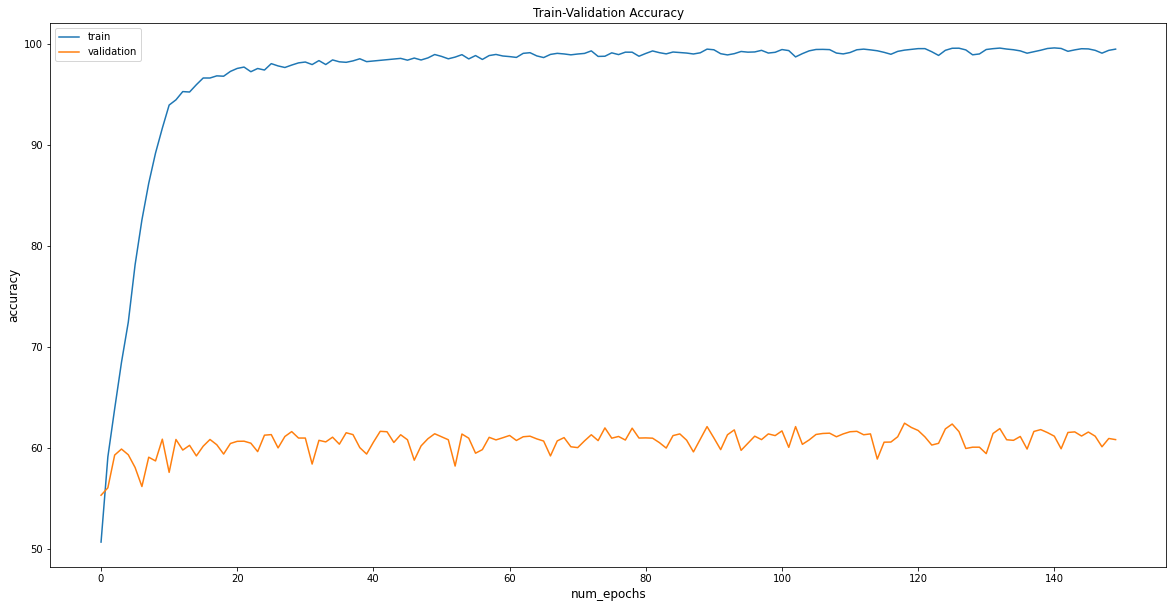

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

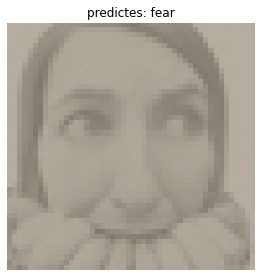

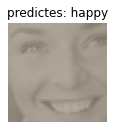

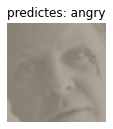

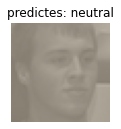

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()